資料來源：https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

path="/Users/z88756212/Documents/AI/python/dogs-vs-cats"
print(os.listdir(path))

['.DS_Store', 'test1', 'Classification.ipynb', 'path_to_save_model', 'practice.ipynb', 'test1.zip', 'train', '.ipynb_checkpoints', 'Cats and dogs.ipynb', 'train.zip']


In [2]:
filenames = os.listdir("/Users/z88756212/Documents/AI/python/dogs-vs-cats/train")
data = []
for filename in filenames:
    
    if "cat" in filename:
        label = "cat"
    elif "dog" in filename:
        label = "dog"
    else:
        label = "unknown" 

    data.append({"filename": filename, "label": label})

df = pd.DataFrame(data)

print(df)

            filename label
0       dog.8011.jpg   dog
1       cat.5077.jpg   cat
2       dog.7322.jpg   dog
3       cat.2718.jpg   cat
4      cat.10151.jpg   cat
...              ...   ...
24995   dog.8008.jpg   dog
24996   dog.1992.jpg   dog
24997  dog.12412.jpg   dog
24998   cat.2701.jpg   cat
24999  cat.10148.jpg   cat

[25000 rows x 2 columns]


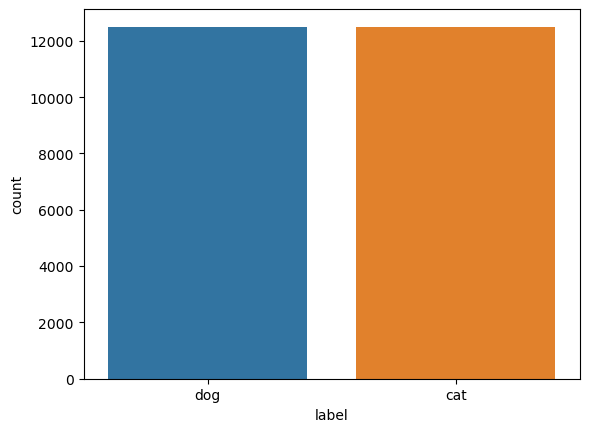

In [5]:
sns.countplot(x="label", data=df); 

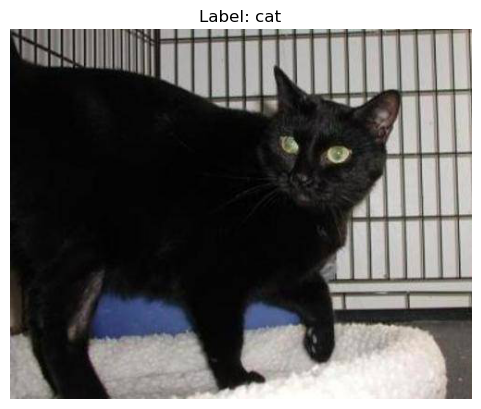

In [7]:
image_dir = "/Users/z88756212/Documents/AI/python/dogs-vs-cats/train"
random_row = df.sample(n=1).iloc[0] 
image_path = os.path.join(image_dir, random_row["filename"])
label = random_row["label"]

img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")  
plt.show()

In [9]:
label_map = {'dog': 1, 'cat': 0}

df['label'] = df['label'].map(label_map).astype(str)
print(df.head())

        filename label
0   dog.8011.jpg     1
1   cat.5077.jpg     0
2   dog.7322.jpg     1
3   cat.2718.jpg     0
4  cat.10151.jpg     0


In [11]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
train_df,validate_df

(            filename label
 0      cat.11282.jpg     0
 1       cat.7693.jpg     0
 2       cat.4977.jpg     0
 3       dog.9403.jpg     1
 4      cat.10150.jpg     0
 ...              ...   ...
 19995   dog.2721.jpg     1
 19996   dog.3974.jpg     1
 19997  dog.10427.jpg     1
 19998    cat.731.jpg     0
 19999   dog.6540.jpg     1
 
 [20000 rows x 2 columns],
            filename label
 0      cat.1474.jpg     0
 1     dog.11287.jpg     1
 2      dog.8276.jpg     1
 3      cat.7227.jpg     0
 4      cat.2997.jpg     0
 ...             ...   ...
 4995   cat.7991.jpg     0
 4996   dog.9208.jpg     1
 4997   cat.5676.jpg     0
 4998   cat.9901.jpg     0
 4999   dog.9535.jpg     1
 
 [5000 rows x 2 columns])

<Axes: xlabel='label'>

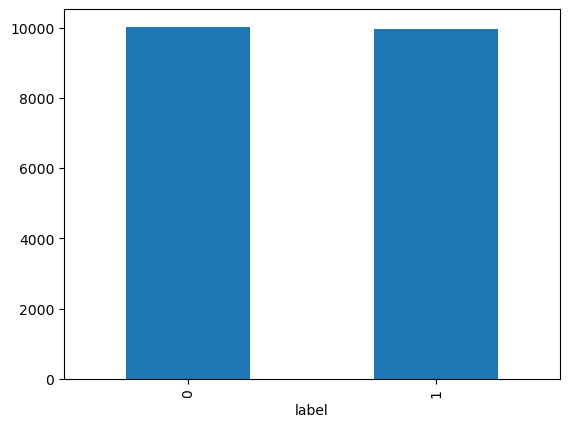

In [15]:
train_df['label'].value_counts().plot.bar()

In [17]:
train_df['label'] = train_df['label'].replace('nan', float('nan'))
train_df = train_df.dropna(subset=['label'])
print(train_df['label'].unique())  

['0' '1']


<Axes: xlabel='label'>

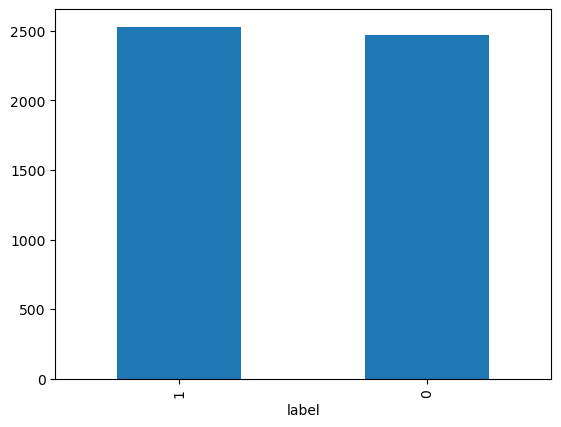

In [19]:
validate_df['label'].value_counts().plot.bar()

# 資料擴增

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    validate_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [23]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,  
    layers.GlobalAveragePooling2D(), 

    layers.Dense(1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")  
])

model.summary()

2025-04-07 20:43:53.463274: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-07 20:43:53.463305: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-07 20:43:53.463311: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-07 20:43:53.463902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-07 20:43:53.464088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=callbacks
)


Epoch 1/20


2025-04-07 20:43:55.063587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 153s 243ms/step - loss: 0.6471 - accuracy: 0.6715 - val_loss: 0.3508 - val_accuracy: 0.8442 - lr: 3.0000e-05
Epoch 2/20
625/625 [==============================] - 151s 242ms/step - loss: 0.5024 - accuracy: 0.7625 - val_loss: 0.2983 - val_accuracy: 0.8726 - lr: 3.0000e-05
Epoch 3/20
625/625 [==============================] - 181s 290ms/step - loss: 0.4639 - accuracy: 0.7857 - val_loss: 0.2844 - val_accuracy: 0.8736 - lr: 3.0000e-05
Epoch 4/20
625/625 [==============================] - 165s 263ms/step - loss: 0.4506 - accuracy: 0.7929 - val_loss: 0.2658 - val_accuracy: 0.8838 - lr: 3.0000e-05
Epoch 5/20
625/625 [==============================] - 168s 269ms/step - loss: 0.4282 - accuracy: 0.8037 - val_loss: 0.2547 - val_accuracy: 0.8898 - lr: 3.0000e-05
Epoch 6/20
625/625 [==============================] - 151s 241ms/step - loss: 0.4135 - accuracy: 0.8097 - val_loss: 0.2482 - val_accuracy: 0.8930 - lr: 3.0000e-05
Epoch 7/20
625/625 [=============

In [25]:
model.save('path_to_save_model/my_model.keras')

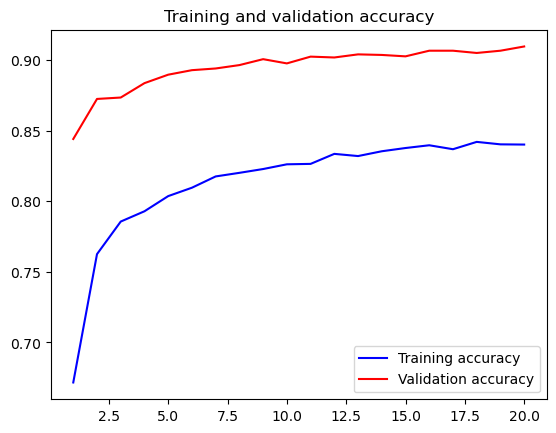

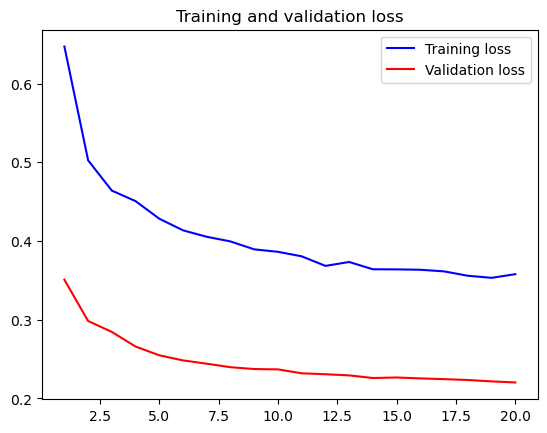

In [26]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color='b', label="Training accuracy")
plt.plot(epochs, val_accuracy, color='r', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, color='b', label="Training loss")
plt.plot(epochs, val_loss, color='r', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [64]:
filenames = os.listdir("/Users/z88756212/Documents/AI/python/dogs-vs-cats/test1")
data = []
for filename in filenames:

    data.append({"filename": filename})

df = pd.DataFrame(data)

print(df)

       filename
0      9733.jpg
1        63.jpg
2      6400.jpg
3       823.jpg
4      4217.jpg
...         ...
12495  3561.jpg
12496  8434.jpg
12497  7707.jpg
12498  6419.jpg
12499  1376.jpg

[12500 rows x 1 columns]


In [73]:
test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory="/Users/z88756212/Documents/AI/python/dogs-vs-cats/test1",
    x_col="filename",
    y_col=None,                   
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,                
    shuffle=False                   
)

Found 12500 validated image filenames.


In [78]:
predictions = model.predict(test_generator)

391/391 [==============================] - 115s 295ms/step


In [80]:
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

In [86]:
df["prediction"] = predicted_labels
df["probability"] = predictions.reshape(-1)
df["class"] = df["prediction"].map({0: "cat", 1: "dog"})

print(df.head())

   filename  prediction  probability class
0  9733.jpg           0     0.066820   cat
1    63.jpg           0     0.006863   cat
2  6400.jpg           1     0.771660   dog
3   823.jpg           1     0.980161   dog
4  4217.jpg           0     0.071996   cat
